In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

# Prepare data
df = pd.read_csv("/content/ames.csv")

<ipython-input-2-1b3592eab501>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


The k-means algorithm is sensitive to scale. This means we need to be thoughtful about how and whether we rescale our features since we might get very different results depending on our choices. As a rule of thumb, if the features are already directly comparable (like a test result at different times), then you would *not* want to rescale. On the other hand, features that aren't on comparable scales (like height and weight) will usually benefit from rescaling. Sometimes, the choice won't be clear though. In that case, you should try to use common sense, remembering that features with larger values will be weighted more heavily.

# 1) Scaling Features

Consider the following sets of features. For each, decide whether:
- they definitely should be rescaled,
- they definitely should *not* be rescaled, or
- either might be reasonable

Features:
1. `Latitude` and `Longitude` of cities in California
2. `Lot Area` and `Living Area` of houses in Ames, Iowa
3. `Number of Doors` and `Horsepower` of a 1989 model car

Once you've thought about your answers, write it below and proceed running the other cell below.

#Write your answer here:
Latitude and Longitude should be rescaled

Lot Area and Living Area should not be scaled as both are quite comparable.

No.of Doors and Horsepower should be rescaled.

-------------------------------------------------------------------------------

# 2) Create a Feature of Cluster Labels

Creating a k-means clustering with the following parameters:
- features: `LotArea`, `TotalBsmtSF`, `FirstFlrSF`, `SecondFlrSF`,`GrLivArea`
- number of clusters: 10
- iterations: 10

(This may take a moment to complete.)

In [3]:
X = df.copy()
y = X.pop("SalePrice")


# YOUR CODE HERE: Define a list of the features to be used for the clustering
features = ["LotArea", "TotalBsmtSF", "FirstFlrSF", "SecondFlrSF", "GrLivArea"]


# Standardize
X_scaled = X.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)


# YOUR CODE HERE: Fit the KMeans model to X_scaled and create the cluster labels
kmeans = KMeans(n_clusters=10, max_iter=10, random_state=0)
X["Cluster"] = kmeans.fit_predict(X_scaled)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


You can run the below cell to see the result of the clustering, if you like.

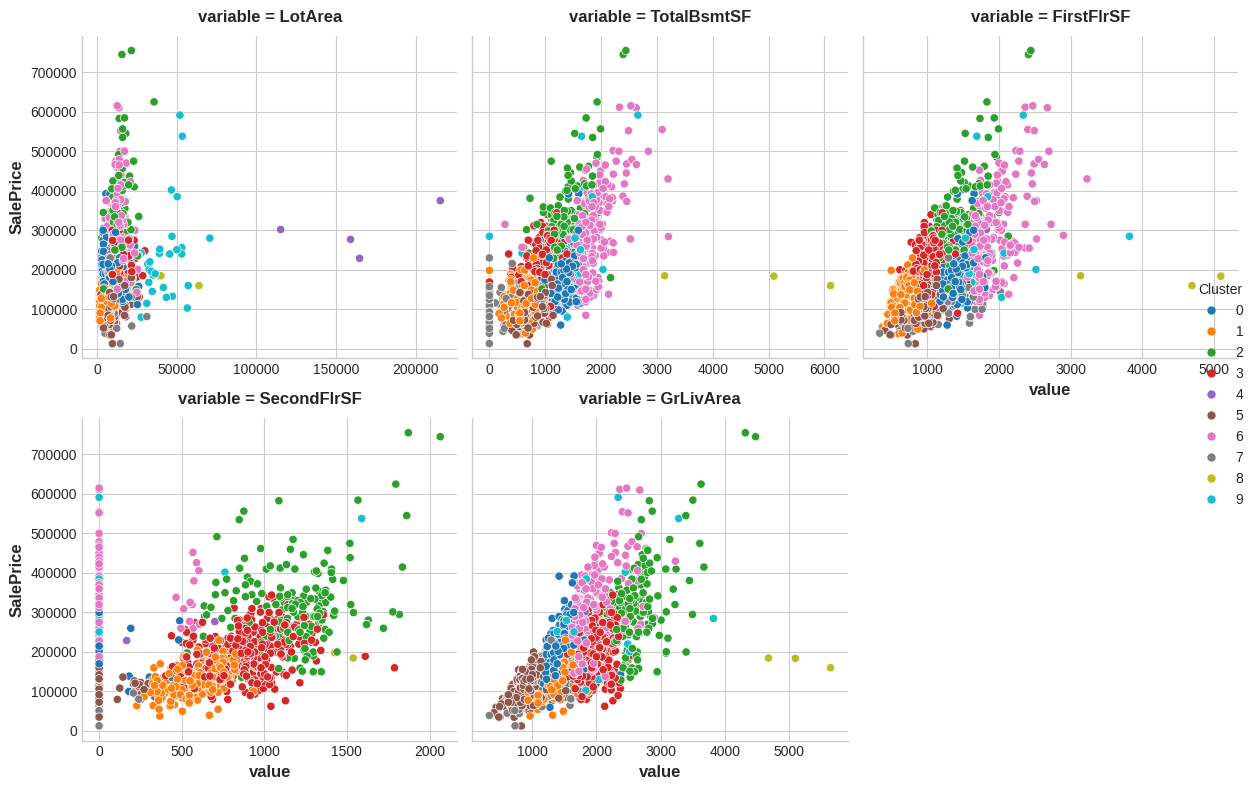

In [4]:
Xy = X.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=Xy.melt(
        value_vars=features, id_vars=["SalePrice", "Cluster"],
    ),
);

And as before, `score_dataset` will score your XGBoost model with this new feature added to training data.

In [5]:
score_dataset(X, y)

0.14414312824062622

-------------------------------------------------------------------------------

The k-means algorithm offers an alternative way of creating features. Instead of labelling each feature with the nearest cluster centroid, it can measure the distance from a point to all the centroids and return those distances as features.

# 3) Cluster-Distance Features

Now add the cluster-distance features to your dataset. You can get these distance features by using the `fit_transform` method of `kmeans` instead of `fit_predict`.

In [6]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)


# YOUR CODE HERE: Create the cluster-distance features using `fit_transform`
X_cd = kmeans.fit_transform(X_scaled)


# Label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)

Run this cell to score these new features, if you like.


In [7]:
score_dataset(X, y)

0.13792696587393843